In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
 # only using 2011-19, to maintain consistent passer IDs
pbp = pd.concat([pd.read_csv(f'pbp_data/play_by_play_{season}.csv.gz', compression='gzip', low_memory=False) for season in range(2011,2020)])

In [3]:
passes = pbp.loc[pbp.pass_attempt==1].copy()
passes['ayts'] = passes['air_yards']-passes['ydstogo']
passes['intended_epa'] = passes['air_epa'] + passes['xyac_epa']

In [4]:
intended_epa = passes.groupby(['season','passer_id']).agg({'play_id':'count'})
for index,down in enumerate(['first','second','third']):
    intended_epa[f'{down}_down_intended_epa'] = passes.loc[passes.down==(index+1)].groupby(['season','passer_id']).agg({'intended_epa':'mean'})
intended_epa['early_down_intended_epa'] = passes.loc[passes.down.isin([1,2])].groupby(['season','passer_id']).agg({'intended_epa':'mean'})
intended_epa['overall_intended_epa'] = passes.groupby(['season','passer_id']).agg({'intended_epa':'mean'})
intended_epa = intended_epa.loc[intended_epa.play_id>=128].reset_index()
intended_epa.head()

,season,passer_id,play_id,first_down_intended_epa,second_down_intended_epa,third_down_intended_epa,early_down_intended_epa,overall_intended_epa
0,2011,32013030-2d30-3030-3730-39316c93ae22,536,0.801440,0.793615,1.309827,0.797749,0.981086
1,2011,32013030-2d30-3031-3130-3232b50875be,172,0.636258,1.041216,1.238901,0.838737,1.015217
2,2011,32013030-2d30-3031-3935-39361b587621,755,0.816917,1.021168,1.455362,0.906153,1.029356
3,2011,32013030-2d30-3032-3032-3435b1d69a2f,441,0.893695,1.182586,1.518177,1.003413,1.143600
4,2011,32013030-2d30-3032-3035-33318e1e348d,791,0.734861,0.936203,1.369268,0.824022,0.942026


In [5]:
# I stole this code from @EthanCDouglas and modified it a bit
def year_to_year_corr(columns, groupby, data):
    cols = [groupby, 'season'] + columns 
    data = data[cols]
    ldata = data.groupby(by=groupby).shift(-1)
    data.columns = [groupby, 'prev_season'] + [f'prev_{col}' for col in columns]
    new_data = pd.concat((data, ldata), axis=1).dropna(subset=['season']).drop(columns=['prev_season','season'])
    tot_corr = new_data.corr(method='pearson')
    num_corr_cols = len(columns)
    corr = tot_corr.iloc[num_corr_cols:,num_corr_cols:]
    pred = tot_corr.iloc[0:num_corr_cols, num_corr_cols:]
    return new_data,corr,pred

yoy_intended_epa_changes,intended_epa_corr,intended_epa_pred = year_to_year_corr(['first_down_intended_epa','second_down_intended_epa','third_down_intended_epa','early_down_intended_epa','overall_intended_epa'],'passer_id',intended_epa)

In [6]:
intended_epa_pred**2

,first_down_intended_epa,second_down_intended_epa,third_down_intended_epa,early_down_intended_epa,overall_intended_epa
prev_first_down_intended_epa,0.111646,0.066600,0.000101,0.129840,0.074302
prev_second_down_intended_epa,0.037570,0.072367,0.031845,0.079458,0.087085
prev_third_down_intended_epa,0.000160,0.054024,0.259119,0.017223,0.110977
prev_early_down_intended_epa,0.102691,0.101905,0.010704,0.152227,0.115788
prev_overall_intended_epa,0.054656,0.126596,0.092950,0.121821,0.170296


Text(0.5, 1.0, 'Year over Year Changes in Average Intended EPA by Down')

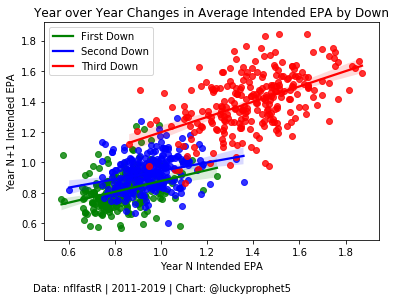

In [7]:
fig,ax = plt.subplots()
downs = ["first","second","third"]
colors = ["g","b","r"]
for i in range(3):
    sns.regplot(x=f"prev_{downs[i]}_down_intended_epa", y=f"{downs[i]}_down_intended_epa", data=yoy_intended_epa_changes, ax=ax, color=colors[i])
ax.legend(["First Down", "Second Down", "Third Down"])
ax.set_xlabel("Year N Intended EPA")
ax.set_ylabel("Year N+1 Intended EPA")
plt.figtext(0.1,-0.05,"Data: nflfastR | 2011-2019 | Chart: @luckyprophet5")
ax.set_title("Year over Year Changes in Average Intended EPA by Down")

Text(0.5, 1, 'Year to Year R^2, intended epa')

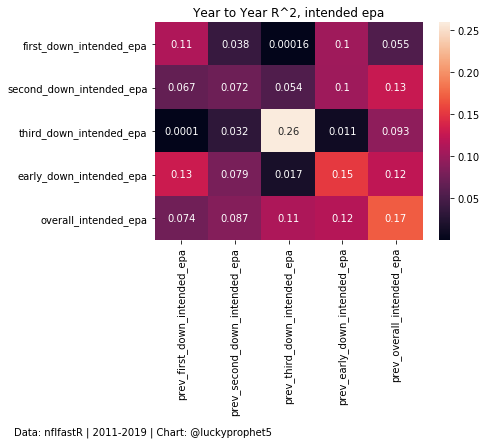

In [8]:
sns.heatmap(intended_epa_pred.transpose()**2, annot=True)
plt.figtext(-0.2,-.55,"Data: nflfastR | 2011-2019 | Chart: @luckyprophet5")
plt.title("Year to Year R^2, intended epa")

Text(0.5, 1, 'R^2, average intended by down')

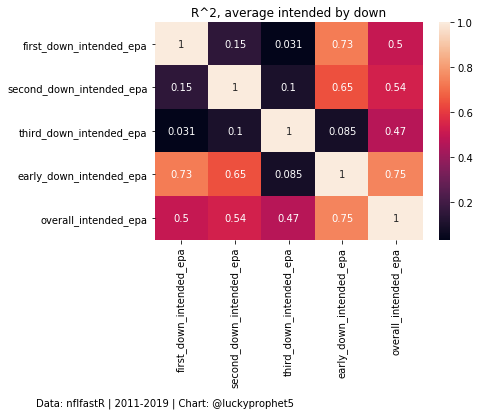

In [9]:
sns.heatmap(intended_epa_corr**2, annot=True)
plt.figtext(-0.15,-.45,"Data: nflfastR | 2011-2019 | Chart: @luckyprophet5")
plt.title("R^2, average intended by down")